# Forward simulation of GPR signals over temperate ice


This notebook reproduce results of Ogier et al "Ground penetrating radar in temperate ice: distribution and size of englacial water inclusions as limiting factors." (in prep)


MORE INTRODUCTION needed here

In [48]:
#import
from math import sqrt
import os
import pandas


**Warning**: be careful with (hiden) open files. This may lead to error when running the code.

# Define and plot the builtin waveform: example for 25MHz

In the ``tools`` sub-package is a module called ``plot_source_wave`` which can be used to plot any of the builtin waveforms in time and frequency domains. The module takes the following arguments:

* ``type`` is the type of the waveform, e.g. ricker
* ``amp`` is the amplitude of the waveform
* ``freq`` is the centre frequency of the waveform
* ``timewindow`` is the time window used to view the waveform, i.e. the time window of the proposed simulation
* ``dt`` is the time step used to view the waveform, i.e. the time step of the proposed simulation

There is an optional argument:

* ``-fft`` a switch to turn on the FFT plotting for a single field component or current

For example (to use the module outside this notebook) to plot a Ricker waveform (and FFT) with an amplitude of 1, centre frequency of 25MHz and with a time window of 150ns and time step of 3.2ns:

    python -m tools.plot_source_wave ricker 1 25e6 3e-9 3.2e-9 -fft

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 0.980419
Centre frequency: 2.5e+07 Hz
Time to centre of pulse: 5.65685e-08 s
Time window: 1.5e-07 s (48 iterations)
Time step: 3.2e-09 s


/home/cogier/miniconda3/envs/gprMax/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


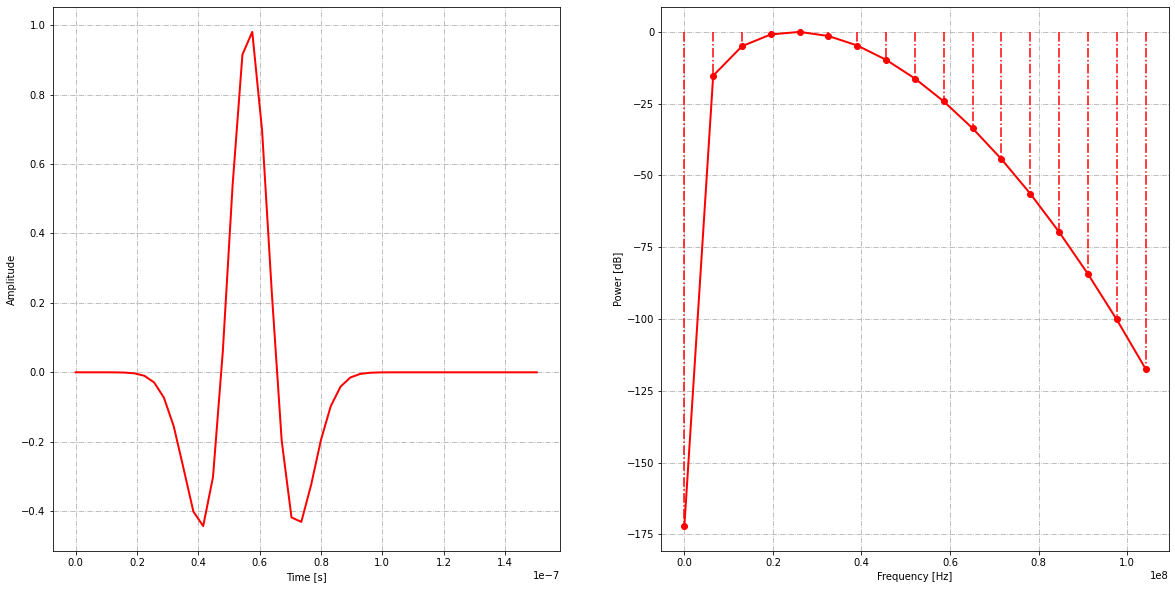

In [37]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 25e6
timewindow = 150e-9
dt = 3.2e-9

timewindow, iterations = check_timewindow(timewindow, dt)
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)

# Determining a suitable spatial model resolution

In [717]:
# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 80 #that is water

# Maximum frequency present in model
fmax = 3*w.freq #3 times the central frequency

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution (allowing 10 cells per wavelength)
dmin = wmin / 10
dmin=0.5
# Time steps at CFL limits for cubic cells
dt3D = dmin / (sqrt(3) * c)
dt2D = dmin / (sqrt(2) * c)

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))
print('Time step for 3D cubic cell: {:g} s'.format(dt3D))
print('Time step for 2D square cell: {:g} s'.format(dt2D))

Minimum wavelength: 0.446904 m
Maximum spatial resolution: 0.5 m
Time step for 3D cubic cell: 9.62917e-10 s
Time step for 2D square cell: 1.17933e-09 s


The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).

# Define time windows

In [810]:
d = 100 #depth of the glacier model
er=3.2 #relative permittivity of ice
t = (2 * d) / (c / sqrt(er))
print('Minimum time window: {:g} s'.format(t))

Minimum time window: 1.1934e-06 s


# Write `.in` files for gprMax

We created the model space in 2D (our "glacier box") with Matlab `glacier_model.m` (See GitHub repository `gpr_in_temperate_ice`).

Below we now write the `.in` file (input for gprMax) using functions in `../gprMax/input_cmd_funcs.py`.

This file set the gpr simulation frame (time space and discretization, materials, frquency...).



See [gprMax doc about building environment](http://docs.gprmax.com/en/latest/examples_simple_2D.html)

In [612]:
#path
direname="../../../gprMax_data/2D_models/" 

In [613]:
#call function input_cmd_funcs.py
from gprMax.input_cmd_funcs import *
# read 'simulations.m' output attributes (parameters values of the matlab models)
models = pandas.read_csv(direname+'models_attributes.txt', sep='\s+', names=['id', 'LWC', 'smax'])
models

,id,LWC,smax
0,1,0.6,0.1
1,2,0.6,0.5
2,3,0.6,1.0
3,4,0.8,0.1
4,5,0.8,0.5
5,6,0.8,1.0
6,7,1.0,0.1
7,8,1.0,0.5
8,9,1.0,1.0


**Note: str(domain(x, y, z)) is the same than '#domain: ' + str(x) + str(y) + str(z)**

### Define constant model parameters (= the same for all simulations)

In [828]:
## Constant model parameters

# Model space discretization in m: See Maximum spatial resolution calculation above
dx=0.05;dy=0.05;dz=0.05

# Model space domain in m
x=100;y=110;z=dz #2D

# Time window in s (see Time window calculation above)
t_window = 1800e-9

# Wave form
shape='ricker';amplitude=1;identifier='my_ricker' #frequency is a free parameter
polarisation='z';
x_source=1;
y_source=105.5; #50 cm above ground
z_source=0 #source coordinates

# Initial receiver position 
yr=y_source;zr=z_source #xr is defined later wuth frequency because receiver and transmitter distance equal one wave length

# Source-transmiteur steps (= trace spacing)
dx_source=0.5 #in m

### Create filenames list (based on the free parameters values: LWC, water inclusions size and frequency)

In [812]:
#create filename list
filename=[] #base name of the file (without .in)
infile=[] #base name with .in -> infile
fname=[] #total path with infile
freq=[25e6,100e6] #GPR frequency in Hz

for j in freq:
    for i in range(0,len(models)):

        filename += ['LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"]
        infile += ['LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"+'.in']
        fname += [direname+'LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"+'.in']

fname
filename


['LWC0.6_smax0.1_freq25MHz',
 'LWC0.6_smax0.5_freq25MHz',
 'LWC0.6_smax1.0_freq25MHz',
 'LWC0.8_smax0.1_freq25MHz',
 'LWC0.8_smax0.5_freq25MHz',
 'LWC0.8_smax1.0_freq25MHz',
 'LWC1.0_smax0.1_freq25MHz',
 'LWC1.0_smax0.5_freq25MHz',
 'LWC1.0_smax1.0_freq25MHz',
 'LWC0.6_smax0.1_freq100MHz',
 'LWC0.6_smax0.5_freq100MHz',
 'LWC0.6_smax1.0_freq100MHz',
 'LWC0.8_smax0.1_freq100MHz',
 'LWC0.8_smax0.5_freq100MHz',
 'LWC0.8_smax1.0_freq100MHz',
 'LWC1.0_smax0.1_freq100MHz',
 'LWC1.0_smax0.5_freq100MHz',
 'LWC1.0_smax1.0_freq100MHz']

## Write input files

In [813]:
for j in freq:
    for i in range(0,len(models)):

        title='LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])+'_freq'+str(round(j/1000000))+"MHz"   #title
        f = open(direname+title+'.in','w+')
        f.write(
        
            '#title: '+title+'\n'+
            '#domain: '+ str(domain(x, y, z))+'\n'+
            '#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
            '#time_window: '+ str(t_window)+'\n'+
            '#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(j)+" "+str(identifier)+'\n'+
            '#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source)+" "+str(z_source)
            +" "+str(identifier)+'\n'+
            '#rx: '+str(x_source+1e8/j)+" "+str(yr)+" "+str(zr)+"\n"
            '#src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
            '#rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
            '#geometry_objects_read: '+ str(0)+" "+str(0)+" "+str(0)+" "+'LWC='+str(models['LWC'][i])+'-smax='+str(models['smax'][i])+'.h5'+" "+'LWC='+str(models['LWC'][i])+'-smax='+str(models['smax'][i])+'_material.txt'+"\n"+
            '#python:'+'\n'
            'from gprMax.input_cmd_funcs import *'+'\n'
            'if current_model_run == 1:'+'\n'
            ' '+' '+ ' '+ ' '+'geometry_view(0, 0, 0,'+str(x) +","+str(y) +","+str(z) +","+str(dx) +","+str(dy) +","+str(dz)+",'"+title+"',"+"'n'"+')'+'\n'
                
            '#end_python:'

            
            
            )
        f.close()
    

#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05


# Write python script to sumurize simulations runs

This will be then run from the terminal

In [816]:
#25 MHz
f = open(direname+'simulations_run_25MHz.py','w+')
f.write(
'from gprMax.gprMax import api'+'\n'
'filename ='+str(infile)+'\n'+
'''path = '/scratch-3/cogier/gprMax_data/2D_models/' '''+'\n'+

'for i in range(0,int(len(filename)/2-1)):'+'\n'
    '''\
    api(path+filename[i],gpu=[0], n=190)
    '''       
)   
f.close()


# Run the models


To run the model to create a B-scan you must pass an optional argument to specify the number of times the model should be run. In this case this is the number of A-scans (traces) that will comprise the B-scan. For a B-scan over a distance of 95m with a step of 0.5m that is 190 A-scans. In the terminal we would use: `python -m gprMax modelX.in -n 190` but here we call the functionm `api` in the sript

## Ready! Go to your terminal and run `$ python simulations_run.py` 

In [759]:
## WARNING: check that `path` defined above matches you terminal path. In our case this is in gprMax_data/2D_models/



## Merge `.out` files 

You should have produced n output files, one for each A-scan, with names ``filename1.out``, ``filename2.out`` etc... These can be combined into a single file using the command:

    python -m tools.outputfiles_merge filename

In [774]:
filename

['LWC0.6_smax0.1_freq25MHz',
 'LWC0.6_smax0.5_freq25MHz',
 'LWC0.6_smax1.0_freq25MHz',
 'LWC0.8_smax0.1_freq25MHz',
 'LWC0.8_smax0.5_freq25MHz',
 'LWC0.8_smax1.0_freq25MHz',
 'LWC1.0_smax0.1_freq25MHz',
 'LWC1.0_smax0.5_freq25MHz',
 'LWC1.0_smax1.0_freq25MHz',
 'LWC0.6_smax0.1_freq100MHz',
 'LWC0.6_smax0.5_freq100MHz',
 'LWC0.6_smax1.0_freq100MHz',
 'LWC0.8_smax0.1_freq100MHz',
 'LWC0.8_smax0.5_freq100MHz',
 'LWC0.8_smax1.0_freq100MHz',
 'LWC1.0_smax0.1_freq100MHz',
 'LWC1.0_smax0.5_freq100MHz',
 'LWC1.0_smax1.0_freq100MHz']

In [806]:
merge_files(direname+filename[0], removefiles=True)

In [763]:
from tools.outputfiles_merge import merge_files
for i in range(0,8):
    merge_files(direname+filename[i], removefiles=True)

OSError: Unable to create file (unable to truncate a file which is already open)

You should see a combined output file ``filename_merged.out``. Delete the original single A-scan output files or keep them with the argument.

### Plot the B-scan

You can plot the B-scan using:

    python -m tools.plot_Bscan fname_merged.out Ez

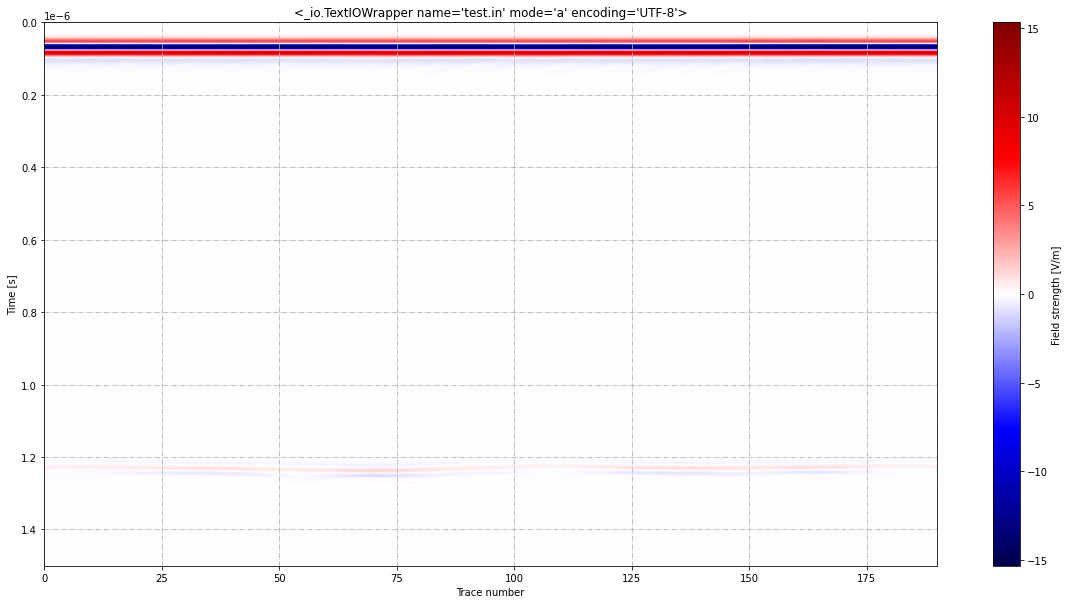

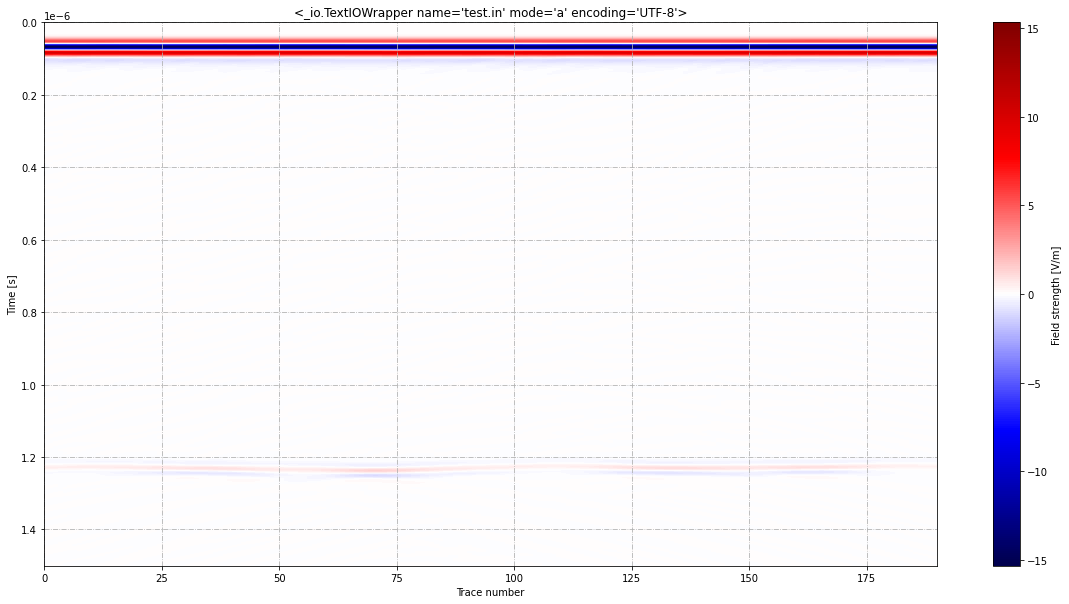

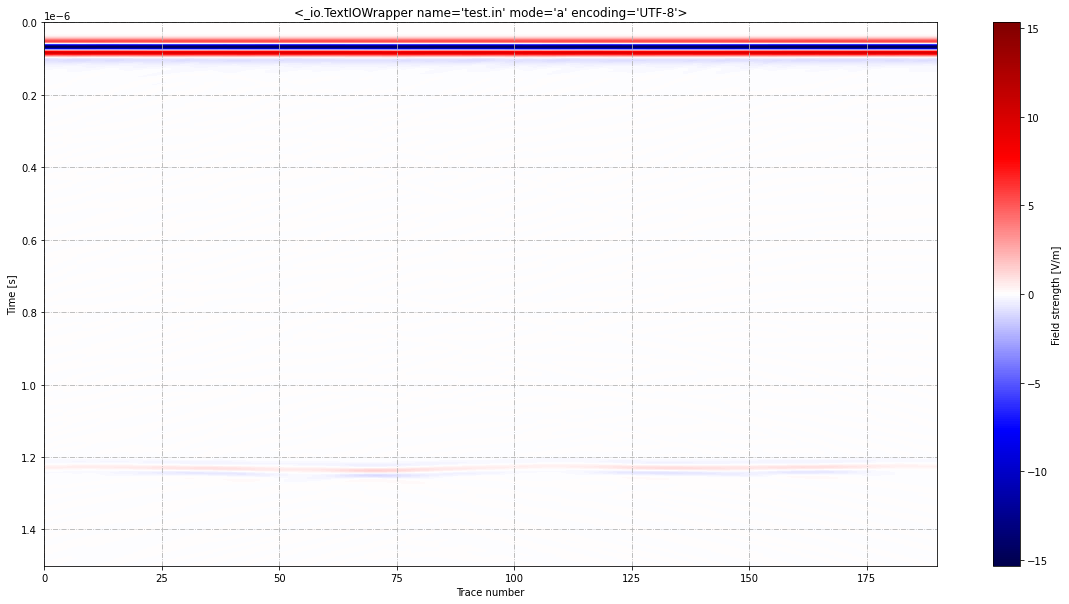

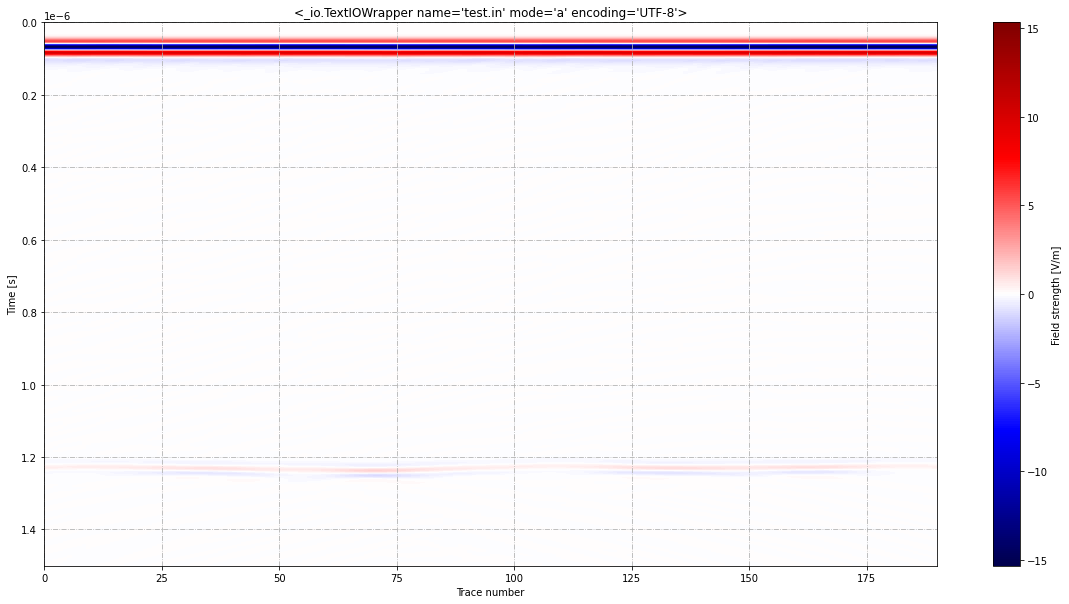

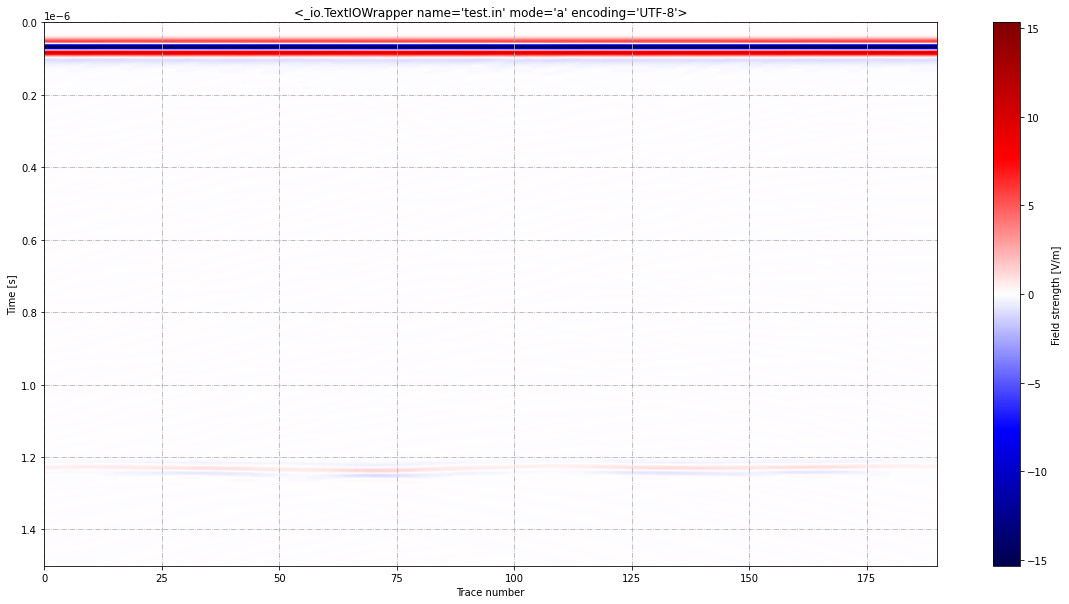

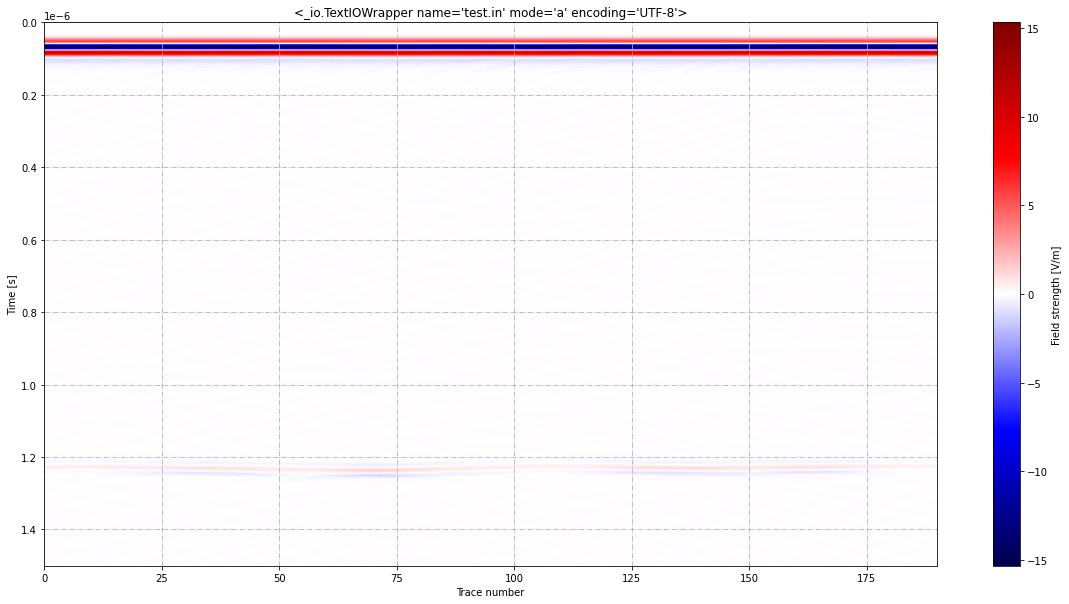

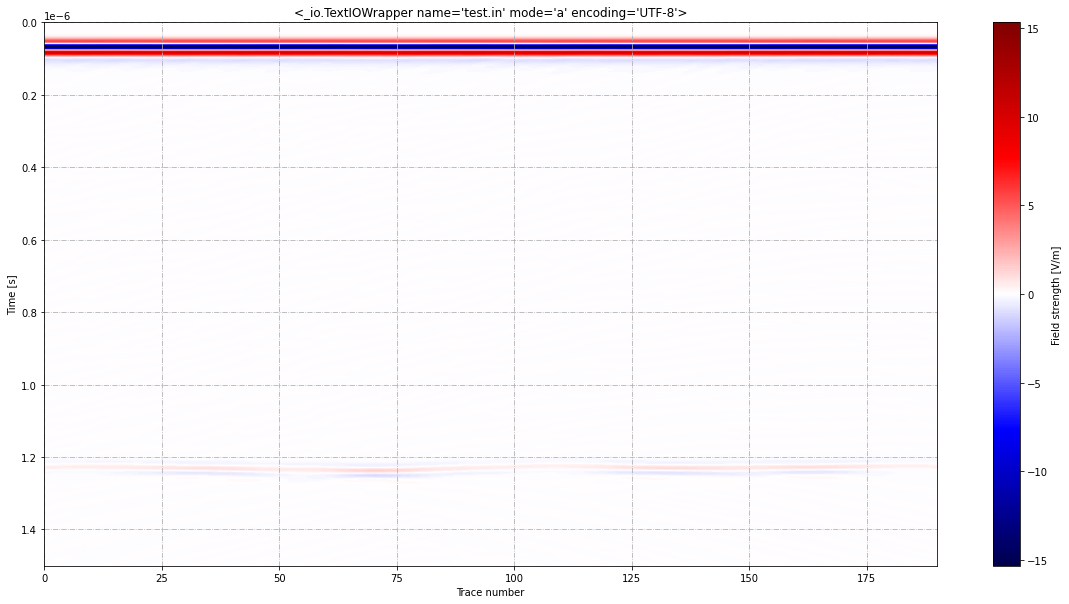

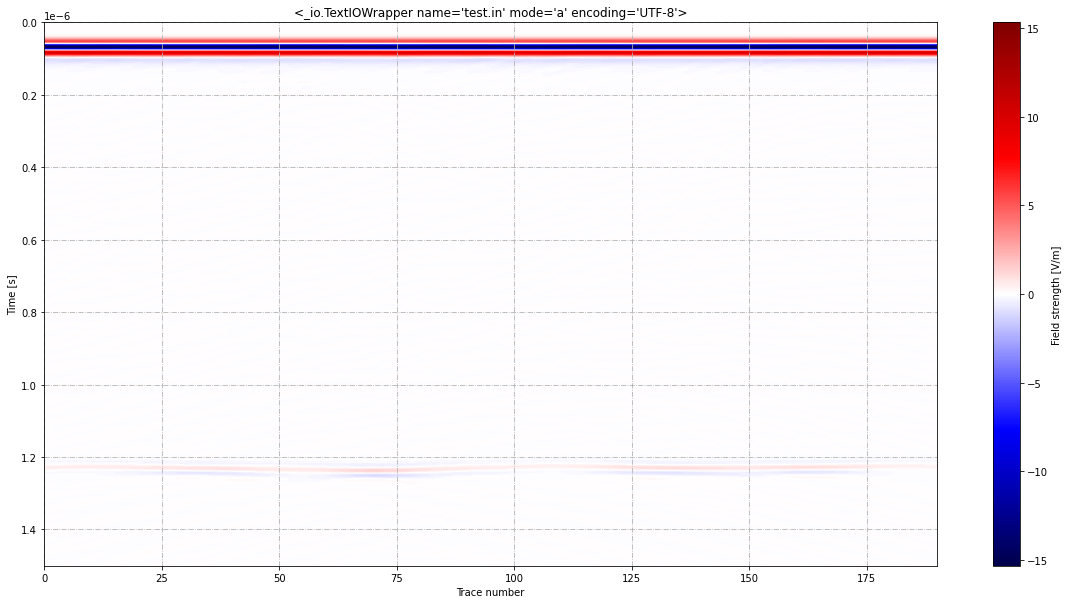

In [778]:
%matplotlib inline
import os
from tools.plot_Bscan import get_output_data, mpl_plot

for i in range(0,8):
    outputname = direname+filename[i]+'_merged.out' #output file path
    rxnumber = 1
    rxcomponent = 'Ez'
    outputdata, dt = get_output_data(outputname, rxnumber, rxcomponent)
    plt = mpl_plot(outputname,outputdata, dt, rxnumber, rxcomponent)
    plt.title(file)
    plt.savefig(direname+filename[i]+'_plot.png')
    # Change from the default 'seismic' colormap
    #plt.set_cmap('gray')

The B-scan (of the $E_z$ field component) shows ....

# Additional Simulations

# Reference model: no scatterers and homogeneous ice

In [ ]:
title='model_ref'
freq=25e6
f = open(direname+title+'.in','w+')
f.write(
        
'#title: '+title+'\n'+
'#domain: '+ str(domain(x, y, z))+'\n'+
'#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
'#time_window: '+ str(t_window)+'\n'+
'#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(freq)+" "+str(identifier)+'\n'+
'#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source)+" "+str(z_source)+" "+str(identifier)+'\n'+
'#rx: '+str(x_source+1e8/freq)+" "+str(yr)+" "+str(zr)+"\n"
'#src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
'#rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
    
'#material: 3.2 5e-8 1 0 ice'+"\n"
'#material: 6 0.001 1 0 granite'+"\n"
'#material: 80 5e-4 1 0 fresh_water'+"\n"    
    
'#box: 0 0 0 100 105 0.05 ice'+"\n"   
'#sphere: 50 5 0 2 fresh_water'+"\n"   #the order matter because it overlaps
'#box: 0 0 0 100 5 0.05 granite'+"\n"   

    
'#python:'+'\n'
'from gprMax.input_cmd_funcs import *'+'\n'
'if current_model_run == 1:'+'\n'
' '+' '+ ' '+ ' '+'geometry_view(0, 0, 0,'+str(x) +","+str(y) +","+str(z) +","+str(dx) +","+str(dy) +","+str(dz)+",'"+title+"',"+"'n'"+')'+'\n'
'#end_python:'
)
f.close()
    

# Model with scatterers but with homogeneous ice (no stochastic distribution)

In [818]:
title='LWC0.6_smax0.1_homo_ice'
freq=25e6
f = open(direname+title+'.in','w+')
f.write(
        
'#title: '+title+'\n'+
'#domain: '+ str(domain(x, y, z))+'\n'+
'#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
'#time_window: '+ str(t_window)+'\n'+
'#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(freq)+" "+str(identifier)+'\n'+
'#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source)+" "+str(z_source)+" "+str(identifier)+'\n'+
'#rx: '+str(x_source+1e8/freq)+" "+str(yr)+" "+str(zr)+"\n"
'#src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
'#rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
'#geometry_objects_read: '+ str(0)+" "+str(0)+" "+str(0)+" "+'LWC=0.6-smax=0.1_homo_ice.h5'+" "+'LWC=0.6-smax=0.1_homo_ice_material.txt'+"\n"+
    
    
'#python:'+'\n'
'from gprMax.input_cmd_funcs import *'+'\n'
'if current_model_run == 1:'+'\n'
' '+' '+ ' '+ ' '+'geometry_view(0, 0, 0,'+str(x) +","+str(y) +","+str(z) +","+str(dx) +","+str(dy) +","+str(dz)+",'"+title+"',"+"'n'"+')'+'\n'
'#end_python:'
)
f.close()
    

#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05


# Define dielectrical properties of snow 

### Snow is not a pre-defined matierial in gprMax, and its conductivity depends of its density and water content.

We calculate the **di-electric permittivity of wet snow** according to Tiuri et al (1984). See also equations (2) and (3) of Griessinger et al (2018). $\epsilon_d$ is the real part of the complex dielectric permittivity of the dry snow, $\epsilon_s$ is the real part of the complex dielectric permittivity of the wet snow, $\epsilon_w$ is the permittivity of the water, $\theta$ is the liquid water content (LWC) and $\rho$ is the dry snow density

$$ \epsilon_d = 1 +1.7\rho + 0.7\rho^2$$
$$ \epsilon_s = (0.1 \theta + 0.8\theta^2)\epsilon_w + \epsilon_d $$ 

In [820]:
#permittivity of wet snow
rho = 0.5 
lwc = 0.03 # 3%
ew = 80 
ed=1 + 1.7*rho + 0.7*rho**2
es=(0.1*lwc + 0.8*lwc**2)*ew + ed
print('permittivity of dry snow is',ed)
print('permittivity of wet snow is',es)

permittivity of dry snow is 2.025
permittivity of wet snow is 2.3226


**The conductivity** is calculated from the formula of Gralund et al 2010:
$$ \sigma \approx  10 + 3.10^3 \times \theta $$
Here $\sigma$ is in $\mu S/m$

In [783]:
#conductivity of wet snow
sig=(10 + 3e3*lwc)/1e6 #conductivity in S/m
print('conductivity of wet snow is',sig,'S/m')

conductivity of wet snow is 0.0001 S/m


# Reference model + wet snow

We add a layer at the glacier surface with the following characteristics:
* snowpack depth= 1m
* density = 0.5
* LWC = 3%

This is taken from typical observations on wet snow pack over alpine glaciers.

In [830]:
#we elevate the antena by 1 meters (so still 50cm above the surface)
y_source_snow = y_source+1
y_source_snow

106.5

### 25e6 MHz 

In [831]:
title='model_ref_snow'
freq=25e6
f = open(direname+title+'.in','w+')
f.write(
        
'#title: '+title+'\n'+
'#domain: '+ str(domain(x, y, z))+'\n'+
'#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
'#time_window: '+ str(t_window)+'\n'+
'#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(freq)+" "+str(identifier)+'\n'+
'#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source_snow)+" "+str(z_source)+" "+str(identifier)+'\n'+
'#rx: '+str(x_source+1e8/freq)+" "+str(yr)+" "+str(zr)+"\n"
'#src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
'#rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
    
'#material: 3.2 5e-8 1 0 ice'+"\n"
'#material: 6 0.001 1 0 granite'+"\n"
'#material: 80 5e-4 1 0 fresh_water'+"\n"  
'#material: 2.32 1e-4 1 0 wet_snow'+"\n"  

    
'#box: 0 0 0 100 105 0.05 ice'+"\n"   
'#sphere: 50 5 0 2 fresh_water'+"\n"   #the order matter because it overlaps
'#box: 0 0 0 100 5 0.05 granite'+"\n"
'#box: 0 105 0 100 106 0.05 wet_snow'+"\n"   
    

    
'#python:'+'\n'
'from gprMax.input_cmd_funcs import *'+'\n'
'if current_model_run == 1:'+'\n'
' '+' '+ ' '+ ' '+'geometry_view(0, 0, 0,'+str(x) +","+str(y) +","+str(z) +","+str(dx) +","+str(dy) +","+str(dz)+",'"+title+"',"+"'n'"+')'+'\n'
'#end_python:'
)
f.close()

#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05


### 100e6 MHz

In [834]:
# Model space discretization in m: See Maximum spatial resolution calculation above
dx=0.01;dy=0.01;dz=0.01
z=dz
# Wave form
shape='ricker';amplitude=1;identifier='my_ricker' #frequency is a free parameter
polarisation='z';
x_source=1;
y_source_snow=y_source+1; #50 cm above ground + 1m snowpack
z_source=0 #source coordinates

In [836]:
title='model_ref_snow_100MHz'
freq=100e6
f = open(direname+title+'.in','w+')
f.write(
        
'#title: '+title+'\n'+
'#domain: '+ str(domain(x, y, z))+'\n'+
'#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
'#time_window: '+ str(t_window)+'\n'+
'#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(freq)+" "+str(identifier)+'\n'+
'#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source_snow)+" "+str(z_source)+" "+str(identifier)+'\n'+
'#rx: '+str(x_source+1e8/freq)+" "+str(yr)+" "+str(zr)+"\n"
'#src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
'#rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
    
'#material: 3.2 5e-8 1 0 ice'+"\n"
'#material: 6 0.001 1 0 granite'+"\n"
'#material: 80 5e-4 1 0 fresh_water'+"\n"  
'#material: 2.32 1e-4 1 0 wet_snow'+"\n"  

    
'#box: 0 0 0 100 105 0.01 ice'+"\n"   
'#sphere: 50 5 0 2 fresh_water'+"\n"   #the order matter because it overlaps
'#box: 0 0 0 100 5 0.01 granite'+"\n"
'#box: 0 105 0 100 106 0.01 wet_snow'+"\n"   
    

    
'#python:'+'\n'
'from gprMax.input_cmd_funcs import *'+'\n'
'if current_model_run == 1:'+'\n'
' '+' '+ ' '+ ' '+'geometry_view(0, 0, 0,'+str(x) +","+str(y) +","+str(z) +","+str(dx) +","+str(dy) +","+str(dz)+",'"+title+"',"+"'n'"+')'+'\n'
'#end_python:'
)
f.close()

#domain: 100 110 0.01
#dx_dy_dz: 0.01 0.01 0.01
